# Starter notebook for phase transitions during training

1. Create local and global datasets
2. Observe loss curves for phase transitions

## Global dataset

We'll train a small transformer to iterate.

*Note: the current setup of Prisma where train config + transformer config are in the same doc is super annoying.* 

### New config 
Putting here instead of creating a config object for visibility.

In [1]:
from dataclasses import dataclass
from vit_prisma.models.layers.transformer_block import TransformerBlock
import torch.nn as nn
from collections import Counter
import random

IMAGE_SIZE = 224
PATCH_SIZE = 56 # 4 patches on width and on height, for a total of 16 patches

@dataclass
class ImageConfig:
    image_size: int = IMAGE_SIZE
    patch_size: int = PATCH_SIZE 
    n_channels: int = 1

@dataclass
class TransformerConfig:
    hidden_dim: int = 128
    num_heads: int = 4
    num_layers: int = 1
    block_fn = TransformerBlock
    mlp_dim: int = hidden_dim * 4  # Use a computed default
    activation_name: str = 'GELU'
    attention_only: bool = False
    attn_hidden_layer: bool = True

@dataclass
class LayerNormConfig:
    qknorm: bool = False
    layer_norm_eps: float = 0.0

@dataclass
class DropoutConfig:
    patch: float = 0.0
    position: float = 0.0
    attention: float = 0.0
    proj: float = 0.0
    mlp: float = 0.0

@dataclass
class InitializationConfig:
    weight_type: str = 'he'
    cls_std: float = 1e-6
    pos_std: float = 0.02

@dataclass
class TrainingConfig:
    loss_fn_name: str = "CrossEntropy"
    lr: float = 1e-4
    num_epochs: int = 2000
    batch_size: int = 256
    warmup_steps: int = 0
    weight_decay: float = 0.0
    max_grad_norm = None
    device: str = 'cuda'
    seed: int = 0
    optimizer_name: str = "AdamW"
    scheduler_step: int = num_epochs
    scheduler_gamma: float = .8
    early_stopping: bool = False

@dataclass
class LoggingConfig:
    log_dir: str = 'logs'
    log_frequency: int = 1
    print_every: int = 0
    use_wandb: bool = True
    wandb_project_name: str = 'phase_transitions'  # Added type annotation
    wandb_team_name: str = 'perceptual-alignment'

@dataclass
class SavingConfig:
    parent_dir: str = "/network/scratch/s/sonia.joseph/vit_prisma"
    save_dir: str = 'checkpoints'
    save_checkpoints: bool = True
    save_cp_frequency: int = 1

class ClassificationConfig:
    num_classes: int = 16
    global_pool: bool = False

@dataclass
class GlobalConfig():
    image: ImageConfig = ImageConfig()
    transformer: TransformerConfig = TransformerConfig()
    layernorm: LayerNormConfig = LayerNormConfig()
    dropout: DropoutConfig = DropoutConfig()
    init: InitializationConfig = InitializationConfig()
    training: TrainingConfig = TrainingConfig()
    logging: LoggingConfig = LoggingConfig()
    saving: SavingConfig = SavingConfig()
    classification: ClassificationConfig = ClassificationConfig()



### Global dataset

 Color in random number of patches. The label for the dataset is the number of patches colored in.

In [3]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import itertools
from torchvision import transforms

class PatchDataset(Dataset):
    def __init__(self, total_images, image_size=28, num_patches=16, transform=None):
        # Validate inputs
        if not np.sqrt(num_patches).is_integer():
            raise ValueError("num_patches must be a perfect square")
        if image_size % np.sqrt(num_patches) != 0:
            raise ValueError("image_size must be divisible by the square root of num_patches")

        self.total_images = total_images
        self.image_size = image_size
        self.num_patches = num_patches
        self.patch_size = image_size // int(np.sqrt(num_patches))
        self.transform = transform

        self.range_start = 6
        self.range_end = 12

        # Generate all unique combinations
        self.all_combinations = list(itertools.chain.from_iterable(
            itertools.combinations(range(num_patches), r) for r in range(self.range_start, self.range_end)
        ))

        if self.total_images > len(self.all_combinations):
            raise ValueError("Requested total images exceed the number of unique combinations available")

        # Shuffle to randomize
        np.random.shuffle(self.all_combinations)

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        # Select combination based on index
        selected_patches = self.all_combinations[idx]
        image = self._generate_image(selected_patches)
        label = len(selected_patches)  # Class label is the number of patches

        if self.transform:
            image = self.transform(image)

        return image, label

    def _generate_image(self, selected_patches):
        image_array = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        num_patch_side = int(np.sqrt(self.num_patches))

        for patch_index in selected_patches:
            row, col = divmod(patch_index, num_patch_side)
            image_array[row * self.patch_size:(row + 1) * self.patch_size, col * self.patch_size:(col + 1) * self.patch_size] = 255

        return Image.fromarray(image_array, 'L')

# Example usage
total_images = 10000  # Adjust as needed
transform = transforms.ToTensor()

patch_dataset = PatchDataset(total_images=total_images, image_size=IMAGE_SIZE, transform=transform)

# Balance dataset to have number of classes as smallest class

# Initialize a Counter to count class occurrences
class_counts = Counter()
# Iterate over the dataset and count classes
for _, label in patch_dataset:
    class_counts[label] += 1

min_class_size = min(class_counts.values())


balanced_global_dataset = []

# Iterate over each class and add a random sample of images to the balanced dataset
for class_label in range(patch_dataset.range_start, patch_dataset.range_end):
    # Filter images of the current class
    class_images = [(image, label) for image, label in patch_dataset if label == class_label]
    
    # Randomly sample images from this class
    balanced_images = random.sample(class_images, min_class_size)
    
    balanced_global_dataset.extend(balanced_images)

# Shuffle the balanced dataset
random.shuffle(balanced_global_dataset)

# Now balanced_global_dataset contains a balanced number of images for each class


In [4]:
class_counts = Counter()
for _, label in balanced_global_dataset:
    class_counts[label] += 1

class_counts

Counter({8: 4368, 11: 4368, 9: 4368, 7: 4368, 10: 4368, 6: 4368})

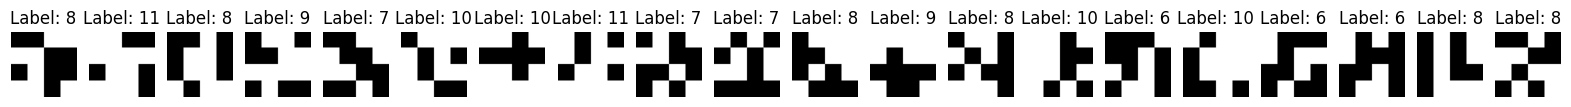

In [5]:
import matplotlib.pyplot as plt
# import transform
from torchvision import transforms


# Plotting the images in a line
num_images=20
fig, axes = plt.subplots(1, num_images, figsize=(20, 2))

for i in range(num_images):
    custom_image, custom_label = balanced_global_dataset[i]
    axes[i].imshow(custom_image[0], cmap='gray')
    axes[i].set_title(f'Label: {custom_label}')
    axes[i].axis('off')


### Local dataset

In [9]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random

class LocalPatchDataset(Dataset):
    def __init__(self, total_images, mnist_dataset, image_size=28, num_patches=16, transform=None):
        self.total_images = total_images
        self.mnist_dataset = mnist_dataset
        self.image_size = image_size
        self.num_patches = num_patches
        self.patch_size = image_size // int(np.sqrt(num_patches))
        self.transform = transform

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        image, label = self._generate_image()
        
        if self.transform:
            image = self.transform(image)

        return image, label

    def _generate_image(self):
        image_array = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        num_patch_side = int(np.sqrt(self.num_patches))

        # Randomly choose a patch to place an MNIST digit
        # Randomly choose a patch to place an MNIST digit
        mnist_index = random.randint(0, len(self.mnist_dataset) - 1)
        mnist_digit, label = self.mnist_dataset[mnist_index]
        mnist_digit = np.array(mnist_digit) * 255  # Rescale to 0-255 and convert to uint8
        mnist_digit = mnist_digit.astype(np.uint8)

        patch_x, patch_y = random.randint(0, num_patch_side - 1), random.randint(0, num_patch_side - 1)
        x_start, y_start = patch_x * self.patch_size, patch_y * self.patch_size

        # Place the MNIST digit into the selected patch
        image_array[x_start:x_start+self.patch_size, y_start:y_start+self.patch_size] = mnist_digit

        return Image.fromarray(image_array, 'L'), label

# Load MNIST Dataset
mnist_transform = transforms.Compose([transforms.Resize((56, 56)), transforms.ToTensor()])
# add to transforms to rescale pixel values to 
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)

# Example usage
local_patch_dataset = LocalPatchDataset(total_images=total_images, mnist_dataset=mnist_dataset, image_size=224, transform=transform)

# Count classes
class_counts = Counter()
for i in range(total_images):
    label = local_patch_dataset[i][1]
    class_counts[label] += 1
print(class_counts)


Counter({1: 1120, 3: 1058, 7: 1052, 9: 1011, 2: 1006, 8: 999, 6: 982, 0: 955, 4: 926, 5: 891})


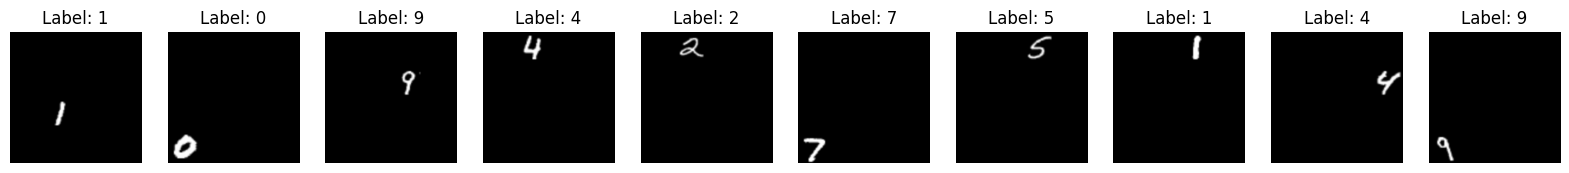

In [10]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    image, label = local_patch_dataset[i]
    axes[i].imshow(image[0], cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

## Train

In [11]:
from vit_prisma.models.base_vit import BaseViT
from vit_prisma.training import trainer



config = GlobalConfig()

config

model_function = BaseViT

# trainer.train(model_function, config, balanced_global_dataset)

trainer.train(model_function, config, local_patch_dataset)



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Split train dataset into train and val with 8000 and 2000.


wandb: Currently logged in as: soniajoseph (perceptual-alignment). Use `wandb login --relogin` to force relogin


Config is: GlobalConfig(image=ImageConfig(image_size=224, patch_size=56, n_channels=1), transformer=TransformerConfig(hidden_dim=128, num_heads=4, num_layers=1, mlp_dim=512, activation_name='GELU', attention_only=False, attn_hidden_layer=True), layernorm=LayerNormConfig(qknorm=False, layer_norm_eps=0.0), dropout=DropoutConfig(patch=0.0, position=0.0, attention=0.0, proj=0.0, mlp=0.0), init=InitializationConfig(weight_type='he', cls_std=1e-06, pos_std=0.02), training=TrainingConfig(loss_fn_name='CrossEntropy', lr=0.0001, num_epochs=2000, batch_size=256, warmup_steps=0, weight_decay=0.0, device='cuda', seed=0, optimizer_name='AdamW', scheduler_step=2000, scheduler_gamma=0.8, early_stopping=False), logging=LoggingConfig(log_dir='logs', log_frequency=1, print_every=0, use_wandb=True, wandb_project_name='phase_transitions', wandb_team_name='perceptual-alignment'), saving=SavingConfig(parent_dir='/network/scratch/s/sonia.joseph/vit_prisma', save_dir='checkpoints', save_checkpoints=True, save

  0%|          | 0/2000 [00:00<?, ?it/s]

Steps0 | Train loss: 0.011111 | Train acc: 0.12012 | Test loss: 0.011117 | Test acc: 0.11400
Steps1 | Train loss: 0.011008 | Train acc: 0.18288 | Test loss: 0.011016 | Test acc: 0.17450
Steps2 | Train loss: 0.010905 | Train acc: 0.26550 | Test loss: 0.010915 | Test acc: 0.24450
Steps3 | Train loss: 0.010804 | Train acc: 0.30075 | Test loss: 0.010815 | Test acc: 0.27800
Steps4 | Train loss: 0.010705 | Train acc: 0.32500 | Test loss: 0.010716 | Test acc: 0.30500
Steps5 | Train loss: 0.010601 | Train acc: 0.34763 | Test loss: 0.010615 | Test acc: 0.33000
Steps6 | Train loss: 0.010497 | Train acc: 0.36412 | Test loss: 0.010514 | Test acc: 0.34500
Steps7 | Train loss: 0.010395 | Train acc: 0.37975 | Test loss: 0.010411 | Test acc: 0.35850
Steps8 | Train loss: 0.010286 | Train acc: 0.38812 | Test loss: 0.010306 | Test acc: 0.36950
Steps9 | Train loss: 0.010177 | Train acc: 0.39663 | Test loss: 0.010199 | Test acc: 0.36950
Steps10 | Train loss: 0.010064 | Train acc: 0.39850 | Test loss: 0.010

KeyboardInterrupt: 

In [ ]:
config.image.image_size 

28

## Local dataset